# TD Learning

In this notebook, we will use TD to solve Cliff Walking environment. 

Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/rl/2019/12/29/Tabular-Solution/#td-learning). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/dudeperf3ct/RL_Notebooks/blob/master/TD/TD_CliffWalking.ipynb)

In [0]:
## We need plotting from lib
# either upload to colab or google drive

# from google.colab import drive
# drive.mount('/content/drive')
# !cp -a drive/My\ Drive/Colab\ Notebooks/RL_Notebooks/lib /content/

In [0]:
import gym
import matplotlib
import numpy as np
import random
import itertools
from collections import defaultdict
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')
%matplotlib inline

### CliffWalking Environment

In this environment, we are given start state(x) and a goal state(T) and along the bottom edge there is a cliff(C). The goal is to find optimal policy to reach the goal state. 

An agent can take 4 actions "up", "right", "down", "left" and reward is -1 for all transitions except those into the region marked "C". Stepping into "C" incurs a reward of -100 and send agent instantly back to start.

![cliff_walk](images/cliff_walk.png)


In [0]:
env = CliffWalkingEnv()

In [14]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [0]:
actions = ["up", "right", "down", "left"]

In [16]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

Number of states: 48
Number of actions that an agent can take: 4


In [17]:
# Where am I? -> in "x" state
print ("Current state", env.s)
# What are my options? -> 4 action
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [18]:
# Taking a step by selecting a random action[up=0, right=1, down=2, left=3] from current state
# next state: Where do I end up?
# reward: What rewards did I recieve?
# is_terminal: did I end up in the goal state?
# t_prob: What is probability of ending up in next state taking that action?
rnd_action = random.randint(0, 3)
print ("Action taken:", actions[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

Action taken: left
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



### SARSA (On-policy)

The goal in sarsa is to find optimal policy.

$$ \begin{aligned} Q(s_{t}, a_{t}) &= Q(s_{t}, a_{t}) + \alpha [R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))]\ \end{aligned} $$

![SARSA](images/sarsa.png)


In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [20]:
%%time 

# generate a episode in cliffwalking environment for above sample_policy
def generate_episode(policy, verbose=False):
    episode = []
    env = CliffWalkingEnv()
    curr_state = env.reset()
    probs = policy(curr_state)
    action = np.random.choice(np.arange(len(probs)), p=probs)
    
    while True:
        if verbose:
            print ("Current observation:")
            print ("Current poistion:", curr_state)
            #print (env.render())
        
        next_obs, reward, is_terminal, _ = env.step(action)
        
        if verbose:
            print ("Action taken:", actions[action])
            print ("Next observation:", next_obs)
            print ("Reward recieved:", reward)
            print ("Terminal state:", is_terminal)
            #print (env.render())
            print ("-"*20)
        episode.append((curr_state, action, reward))
        
        # Pick the next action
        next_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
    
        curr_state = next_obs
        action = next_action

        if (is_terminal):
            break

    return episode
    
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)
e = generate_episode(policy)
#print ("Episode:", e)
print ("Length of episode:", len(e))

Length of episode: 133779
CPU times: user 6.2 s, sys: 29.3 ms, total: 6.23 s
Wall time: 6.21 s


In [0]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Takes a lot a lot lot of time to run
        # ep = generate_episode(policy)
        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, stats

In [24]:
%%time
Q, stats = sarsa(env, 200)

Episode 200/200.CPU times: user 374 ms, sys: 18.4 ms, total: 393 ms
Wall time: 373 ms


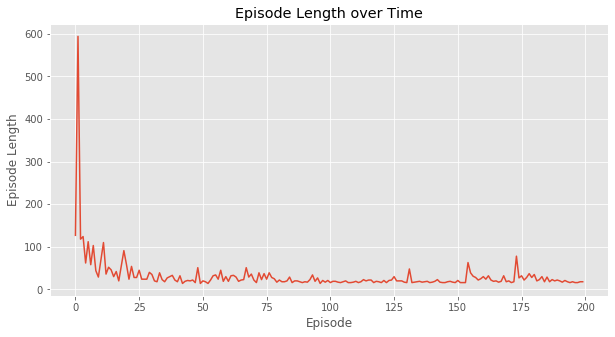

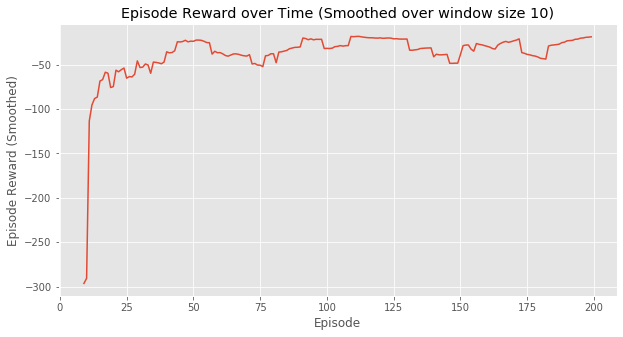

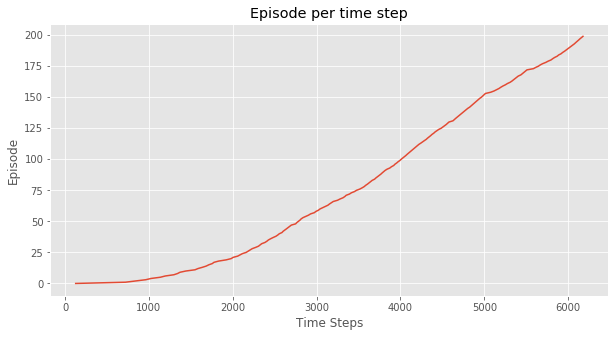

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [25]:
plotting.plot_episode_stats(stats)

### Q-Learning

The goal in Q-learning is to find optimal policy while following $\epsilon$-greedy policy.

![QL](images/ql.png)


In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [0]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # ep = generate_episode(policy, False)

        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]

        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)

        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [31]:
%%time
Q, stats = q_learning(env, 500)

Episode 500/500.CPU times: user 161 ms, sys: 1.04 ms, total: 162 ms
Wall time: 161 ms


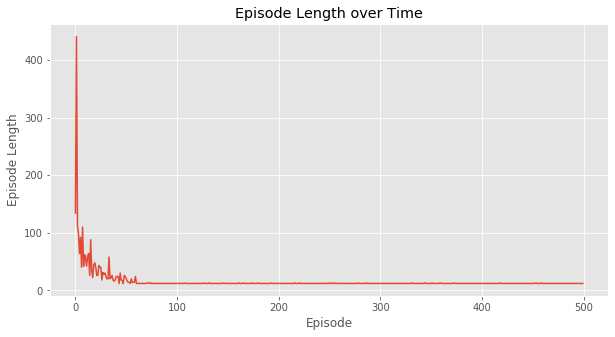

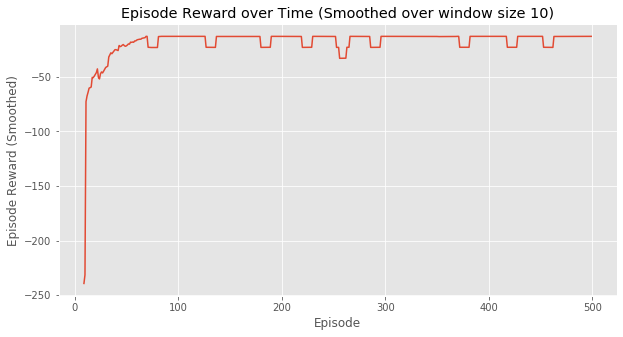

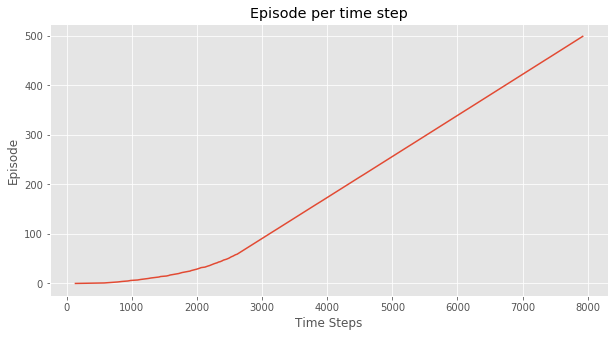

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [32]:
plotting.plot_episode_stats(stats)